In [30]:
import numpy as np
import tensorflow as tf
tf.reset_default_graph()
from tensorflow.examples.tutorials.mnist import input_data
from utils import tile_raster_images
import math
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['image.cmap'] = 'jet'

In [31]:
mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)
trX, trY, teX, teY = mnist.train.images, mnist.train.labels, mnist.test.images, mnist.test.labels

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


<h1> TASK 1 </h1>

<h2> Weights, bias and samples initializer </h2>

In [32]:
def weights(shape):
    initial = tf.truncated_normal(shape, stddev=0.1)
    return tf.Variable(initial)

def bias(shape):
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)

def sample_prob(probs):
    """Uzorkovanje vektora x prema vektoru vjerojatnosti p(x=1) = probs"""
    return tf.to_float(tf.random_uniform(tf.shape(probs)) <= probs)

<h2> Drawing utils </h2>

In [33]:
def draw_weights(W, shape, N, stat_shape, interpolation="bilinear"):
    """Vizualizacija težina
    W -- vektori težina
    shape -- tuple dimenzije za 2D prikaz težina - obično dimenzije ulazne slike, npr. (28,28)
    N -- broj vektora težina
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    """
    image = (tile_raster_images(
        X=W.T,
        img_shape=shape,
        tile_shape=(int(math.ceil(N/stat_shape[0])), stat_shape[0]),
        tile_spacing=(1, 1)))
    plt.figure(figsize=(10, 14))
    plt.imshow(image, interpolation=interpolation)
    plt.axis('off')
    
def draw_reconstructions(ins, outs, states, shape_in, shape_state, N):
    """Vizualizacija ulaza i pripadajućih rekonstrukcija i stanja skrivenog sloja
    ins -- ualzni vektori
    outs -- rekonstruirani vektori
    states -- vektori stanja skrivenog sloja
    shape_in -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    N -- broj uzoraka
    """
    plt.figure(figsize=(8, int(2 * N)))
    for i in range(N):
        plt.subplot(N, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 3)
        plt.imshow(states[i].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("States")
        plt.axis('off')
    plt.tight_layout()

def draw_generated(stin, stout, gen, shape_gen, shape_state, N):
    """Vizualizacija zadanih skrivenih stanja, konačnih skrivenih stanja i pripadajućih rekonstrukcija
    stin -- početni skriveni sloj 
    stout -- rekonstruirani vektori
    gen -- vektori stanja skrivenog sloja
    shape_gen -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    N -- broj uzoraka
    """
    plt.figure(figsize=(8, int(2 * N)))
    for i in range(N):

        plt.subplot(N, 4, 4*i + 1)
        plt.imshow(stin[i].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("set state")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 2)
        plt.imshow(stout[i][0:784].reshape(shape_state), vmin=0, vmax=1, interpolation="nearest")
        plt.title("final state")
        plt.axis('off')
        plt.subplot(N, 4, 4*i + 3)
        plt.imshow(gen[i].reshape(shape_gen), vmin=0, vmax=1, interpolation="nearest")
        plt.title("generated visible")
        plt.axis('off')
    plt.tight_layout()

<h2> CONFIG </h2>

In [34]:
Nh = 100 # Broj elemenata prvog skrivenog sloja
h1_shape = (10,10)
Nv = 784 # Broj elemenata vidljivog sloja
v_shape = (28,28)
Nu = 5000 # Broj uzoraka za vizualizaciju rekonstrukcije

gibbs_sampling_steps = 1
alpha = 0.1

batch_size = 100
epochs = 100
n_samples = mnist.train.num_examples
total_batch = int(n_samples / batch_size) * epochs

In [35]:
# vizualizacija jedne rekonstrukcije s postepenim dodavanjem doprinosa aktivnih skrivenih elemenata
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

g1 = tf.Graph()
with g1.as_default():
        
    X1 = tf.placeholder("float", [None, 784])
    sampled_X1 = sample_prob(X1)
    w1 = weights([Nv, Nh])
    vb1 = bias([Nv])
    hb1 = bias([Nh])
    
    #print ("w1:", w1.shape)
    #print("X1:", X1.shape)
    #print("vb1:", vb1.shape)
    #print("hb1:",hb1.shape)
    
    h0_prob = tf.nn.sigmoid(tf.matmul(sampled_X1, w1) + tf.transpose(hb1))
    h0 = sample_prob(h0_prob)
    h1 = h0
    
    #print ("h1:", h1.shape)

    for step in range(gibbs_sampling_steps):
        v1_prob = tf.nn.sigmoid(tf.matmul(h1, tf.transpose(w1)) + tf.transpose(vb1))
        v1 = sample_prob(v1_prob)
        #print("v1:", v1.shape)
        h1_prob = tf.nn.sigmoid(tf.matmul(v1, w1) + tf.transpose(hb1))
        h1 = sample_prob(h1_prob)
        
    
    w1_positive_grad = tf.matmul(tf.transpose(X1), h0_prob)
    w1_negative_grad = tf.matmul(tf.transpose(v1_prob), h1_prob)
    
    #print ("w1_positive: ", w1_positive_grad.shape)
    #print ("w1_negative: ", w1_negative_grad.shape)

    dw1 = (w1_positive_grad - w1_negative_grad) / tf.to_float(tf.shape(X1)[0])

    update_w1 = tf.assign_add(w1, alpha * dw1)
    update_vb1 = tf.assign_add(vb1, alpha * tf.reduce_mean(sampled_X1 - v1, 0))
    update_hb1 = tf.assign_add(hb1, alpha * tf.reduce_mean(h0 - h1, 0)) 

    out1 = (update_w1, update_vb1, update_hb1)
    
    #print ("update_w1: ", update_w1.shape)
    
    v1_prob = tf.nn.sigmoid(tf.matmul(h1, tf.transpose(w1)) + tf.transpose(vb1))
    v1 = sample_prob(v1_prob)
    
    #print ("v1 last:", v1.shape)
    
    err1 = X1 - v1_prob
    #print("error: ", err1.shape)
    err_sum1 = tf.reduce_mean(err1 * err1)
    
    initialize1 = tf.global_variables_initializer()

In [36]:
sess1 = tf.Session(graph=g1)
sess1.run(initialize1)

for i in range(total_batch):
    batch, label = mnist.train.next_batch(batch_size)
    #print(batch.shape)
    err, _ = sess1.run([err_sum1, out1], feed_dict={X1: batch})
        
    if i%(int(total_batch/10)) == 0:
        print(i, err)

w1s = w1.eval(session=sess1)
vb1s = vb1.eval(session=sess1)
hb1s = hb1.eval(session=sess1)
vr, h1s = sess1.run([v1_prob, h1], feed_dict={X1: teX[0:Nu,:]})

0 0.25610128
5500 0.023496386
11000 0.022748344
16500 0.022191215
22000 0.020681795
27500 0.021235274
33000 0.019548982
38500 0.020397333
44000 0.01803853
49500 0.020269703


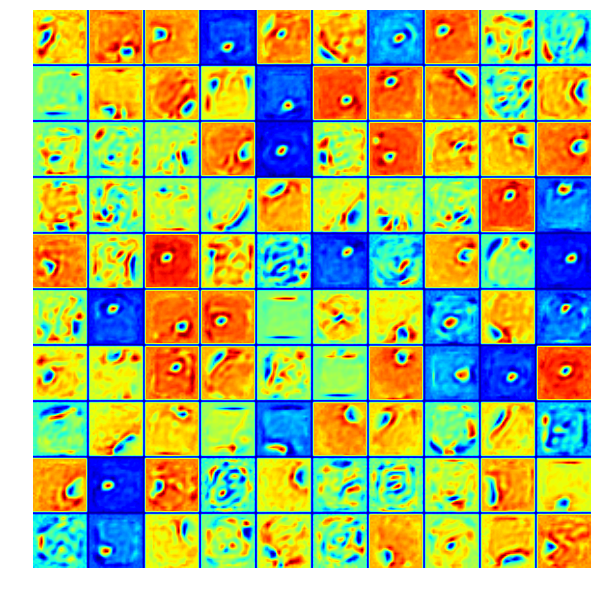

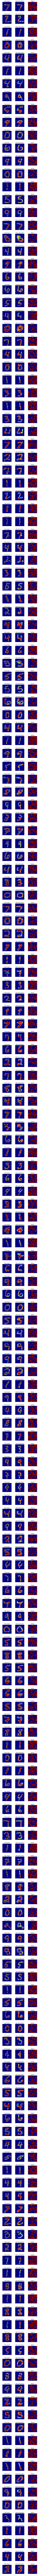

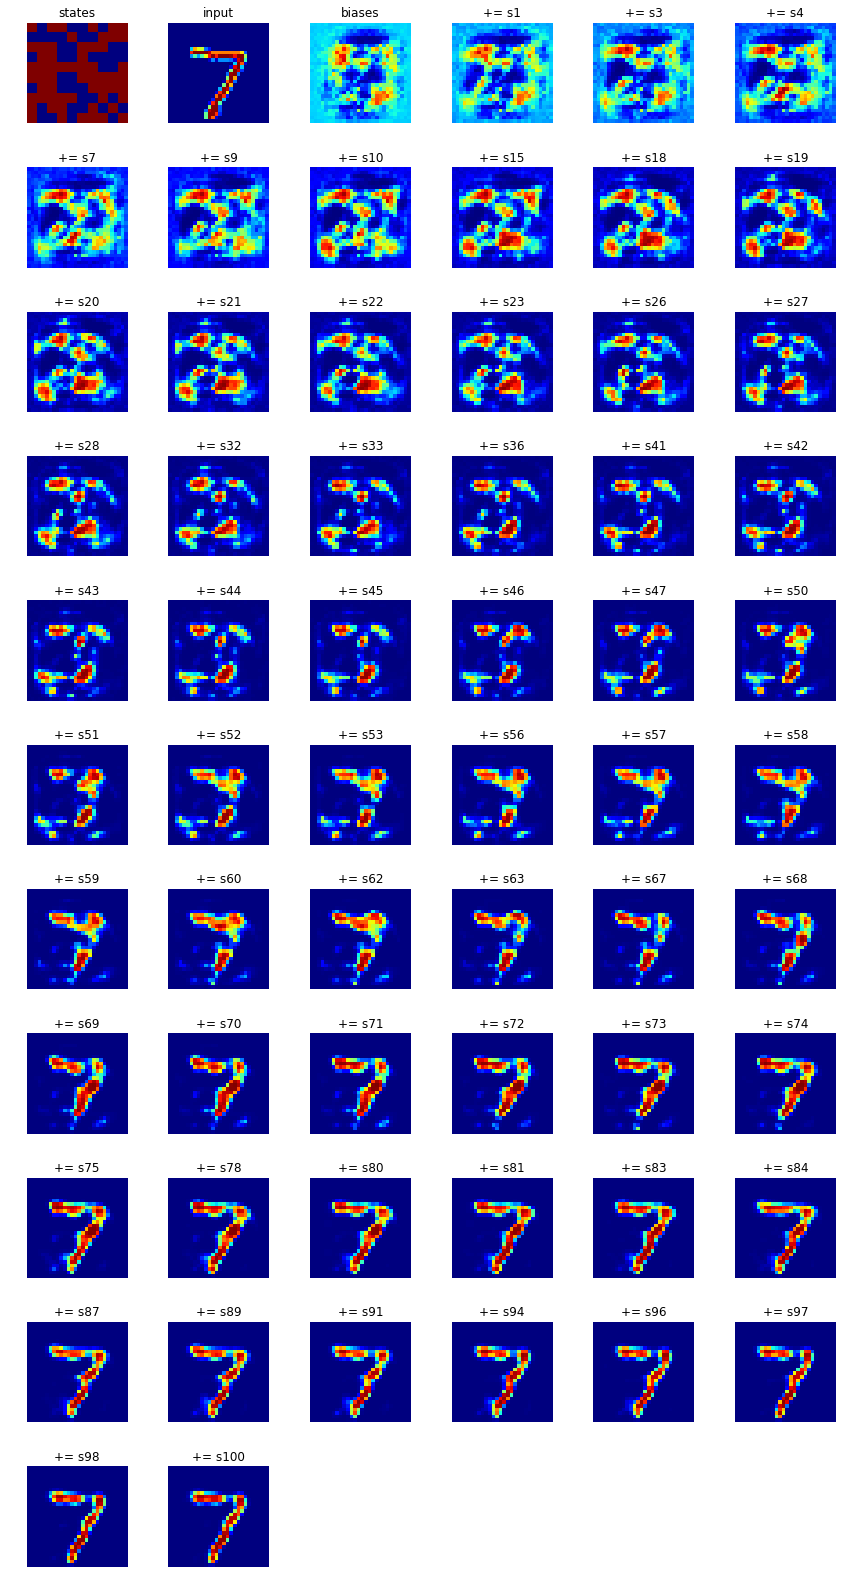

In [37]:
# vizualizacija težina
draw_weights(w1s, v_shape, Nh, h1_shape)

# vizualizacija rekonstrukcije i stanja
draw_reconstructions(teX, vr, h1s, v_shape, h1_shape, 200)

def draw_rec(inp, title, size, Nrows, in_a_row, j):
    """ Iscrtavanje jedne iteracije u kreiranju vidljivog sloja
    inp - vidljivi sloj
    title - naslov sličice
    size - 2D dimenzije vidljiovg sloja
    Nrows - maks. broj redaka sličica
    in-a-row . broj sličica u jednom redu
    j - pozicija sličice u gridu
    """
    plt.subplot(Nrows, in_a_row, j)
    plt.imshow(inp.reshape(size), vmin=0, vmax=1, interpolation="nearest")
    plt.title(title)
    plt.axis('off')
    
    
def reconstruct(ind, states, orig, weights, biases):
    """ Slijedno iscrtavanje rekonstrukcije vidljivog sloja
    ind - indeks znamenke u orig (matrici sa znamenkama kao recima)
    states - vektori stanja ulaznih vektora
    orig - originalnalni ulazni vektori
    weights - matrica težina
    biases - vektori pomaka vidljivog sloja
    """
    j = 1
    in_a_row = 6
    Nimg = states.shape[1] + 3
    Nrows = int(np.ceil(float(Nimg+2)/in_a_row))
    
    plt.figure(figsize=(12, 2*Nrows))
       
    draw_rec(states[ind], 'states', h1_shape, Nrows, in_a_row, j)
    j += 1
    draw_rec(orig[ind], 'input', v_shape, Nrows, in_a_row, j)
    
    reconstr = biases.copy()
    j += 1
    draw_rec(sigmoid(reconstr), 'biases', v_shape, Nrows, in_a_row, j)
    
    for i in range(Nh):
        if states[ind,i] > 0:
            j += 1
            reconstr = reconstr + weights[:,i]
            titl = '+= s' + str(i+1)
            draw_rec(sigmoid(reconstr), titl, v_shape, Nrows, in_a_row, j)
    plt.tight_layout()
    
reconstruct(0, h1s, teX, w1s, vb1s) # prvi argument je indeks znamenke u matrici znamenki

Text(0.5,1,'Sortirane matrice tezina - od najucestalijih do najmanje koristenih')

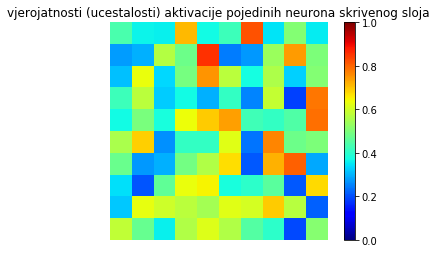

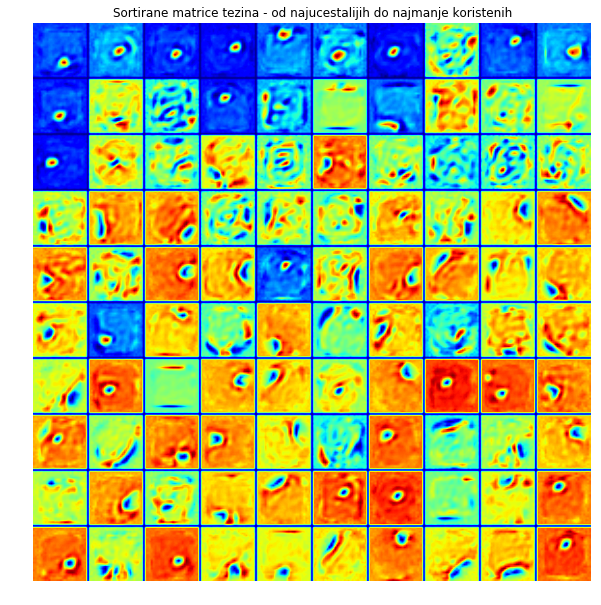

In [38]:
# Vjerojatnost da je skriveno stanje uključeno kroz Nu ulaznih uzoraka
plt.figure()
tmp = (h1s.sum(0)/h1s.shape[0]).reshape(h1_shape)
plt.imshow(tmp, vmin=0, vmax=1, interpolation="nearest")
plt.axis('off')
plt.colorbar()
plt.title('vjerojatnosti (ucestalosti) aktivacije pojedinih neurona skrivenog sloja')

# Vizualizacija težina sortitranih prema učestalosti
tmp_ind = (-tmp).argsort(None)
draw_weights(w1s[:, tmp_ind], v_shape, Nh, h1_shape)
plt.title('Sortirane matrice tezina - od najucestalijih do najmanje koristenih')

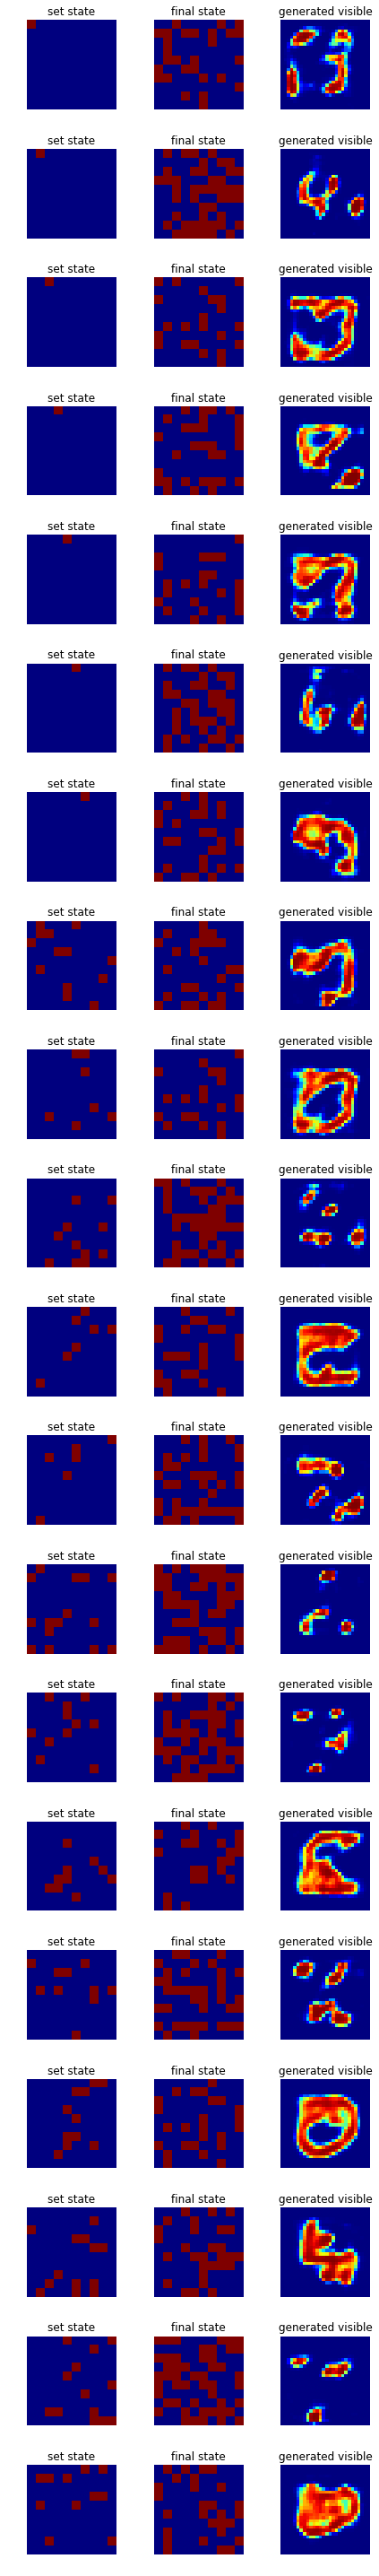

In [39]:
# Generiranje uzoraka iz slučajnih vektora
r_input = np.random.rand(100, Nh)
r_input[r_input > 0.9] = 1 # postotak aktivnih - slobodno varirajte
r_input[r_input < 1] = 0
r_input = r_input * 20 # pojačanje za slučaj ako je mali postotak aktivnih

s = 10
i = 0
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s

out_1 = sess1.run((v1), feed_dict={h0: r_input})

# Emulacija dodatnih Gibbsovih uzorkovanja pomoću feed_dict
for i in range(1000):
    out_1_prob, out_1, hout1 = sess1.run((v1_prob, v1, h1), feed_dict={X1: out_1})

draw_generated(r_input, hout1, out_1_prob, v_shape, h1_shape, 20)

<h1> TASK 2 </h1>

<h2> Config </h2>

In [40]:
Nh2 = Nh # Broj elemenata drugog skrivenog sloja
h2_shape = h1_shape 

gibbs_sampling_steps = 2
alpha = 0.1

batch_size = 100
epochs = 100
n_samples = mnist.train.num_examples

total_batch = int(n_samples / batch_size) * epochs

In [41]:
g2 = tf.Graph()
with g2.as_default():
    
    X2 = tf.placeholder("float", [None, Nv])
    w1a = tf.Variable(w1s)
    vb1a = tf.Variable(vb1s)
    hb1a = tf.Variable(hb1s)
    w2 = weights([Nh, Nh2])
    hb2 = bias([Nh2])

    h1up_prob = tf.nn.sigmoid(tf.matmul(X2, w1a) + tf.transpose(hb1a))
    h1up = sample_prob(h1up_prob)
    h2up_prob = tf.nn.sigmoid(tf.matmul(h1up, w2) + tf.transpose(hb2))
    h2up = sample_prob(h2up_prob)
    h2down = h2up

    for step in range(gibbs_sampling_steps):
        h1down_prob = tf.nn.sigmoid(tf.matmul(h2down, tf.transpose(w2)) + tf.transpose(hb1a))
        h1down = sample_prob(h1down_prob)
        h2down_prob = tf.nn.sigmoid(tf.matmul(h1down, w2) + tf.transpose(hb2))
        h2down = sample_prob(h2down_prob)

    w2_positive_grad = tf.matmul(tf.transpose(h1up_prob), h2up_prob)
    w2_negative_grad = tf.matmul(tf.transpose(h1down_prob), h2down_prob)

    dw2 = (w2_positive_grad - w2_negative_grad) / tf.to_float(tf.shape(h1up)[0])

    update_w2 = tf.assign_add(w2, alpha * dw2)
    update_hb1a = tf.assign_add(hb1a, alpha * tf.reduce_mean(h1up - h1down, 0))
    update_hb2 = tf.assign_add(hb2, alpha * tf.reduce_mean(h2up - h2down, 0))

    out2 = (update_w2, update_hb1a, update_hb2)

    # rekonstrukcija ulaza na temelju krovnog skrivenog stanja h3
    # ...
    # ...
    h1_out_prob = tf.nn.sigmoid(tf.matmul(h2down, tf.transpose(w2)) + tf.transpose(hb1a))
    h1_out = sample_prob(h1_out_prob)
    v_out_prob = tf.nn.sigmoid(tf.matmul(h1_out, tf.transpose(w1a)) + tf.transpose(vb1a))
    v_out = sample_prob(v_out_prob)


    err2 = X2 - v_out_prob
    err_sum2 = tf.reduce_mean(err2 * err2)

    initialize2 = tf.global_variables_initializer()

In [42]:
sess2 = tf.Session(graph=g2)
sess2.run(initialize2)
for i in range(total_batch):
    # iteracije treniranja 
    #...
    #...
    batch, label = mnist.train.next_batch(batch_size)
    err, _ = sess2.run([err_sum2, out2], feed_dict={X2: batch})
    if i%(int(total_batch/10)) == 0:
        print(i, err)
    
        
w2s, hb1as, hb2s = sess2.run([w2, hb1a, hb2], feed_dict={X2: batch})
vr2, h2downs = sess2.run([v_out_prob, h2down], feed_dict={X2: teX[0:Nu,:]})

0 0.109413415
5500 0.047857545
11000 0.041665792
16500 0.043727055
22000 0.043864816
27500 0.041809004
33000 0.042834837
38500 0.0417146
44000 0.042846233
49500 0.04305119


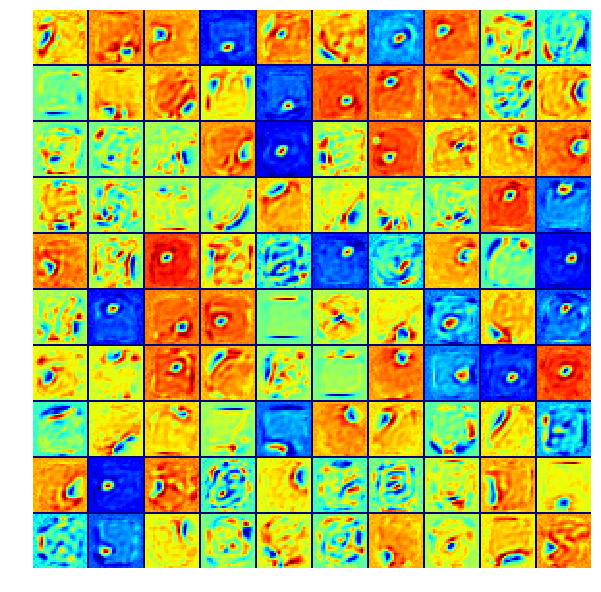

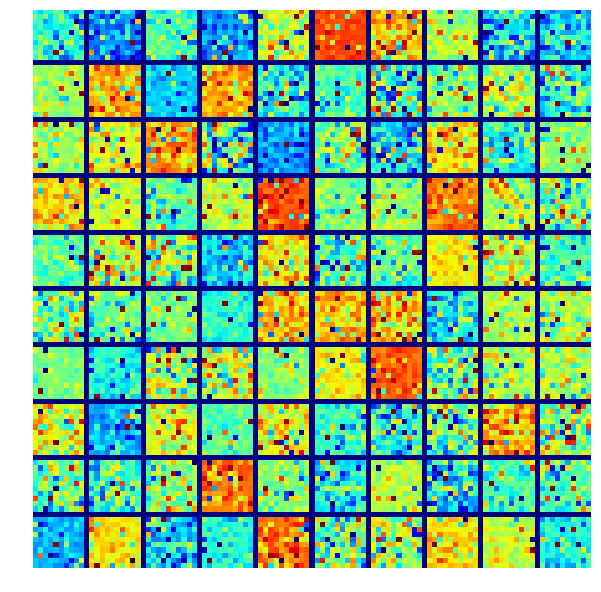

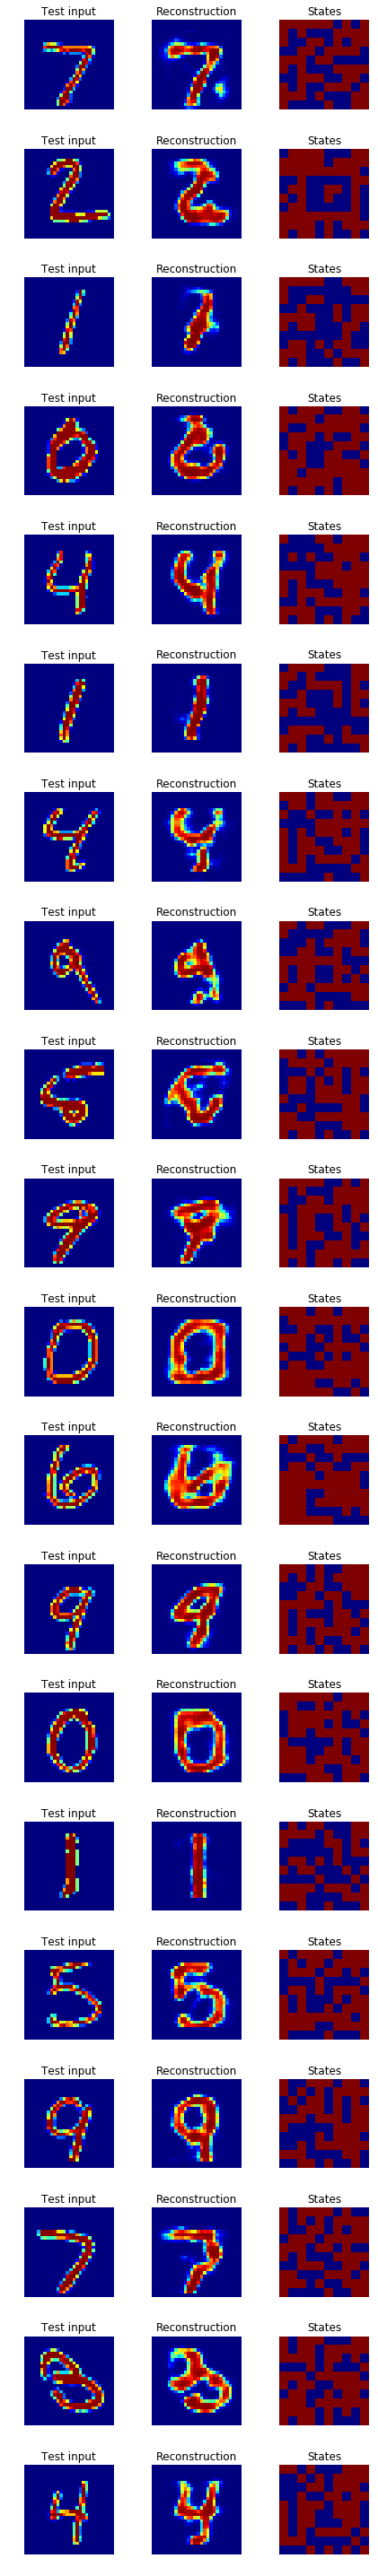

In [43]:
# vizualizacija težina
draw_weights(w1s, v_shape, Nh, h1_shape, interpolation="nearest")

draw_weights(w2s, h1_shape, Nh2, h2_shape, interpolation="nearest")

# vizualizacija rekonstrukcije i stanja
draw_reconstructions(teX, vr2, h2downs, v_shape, h2_shape, 20)

(100, 784)


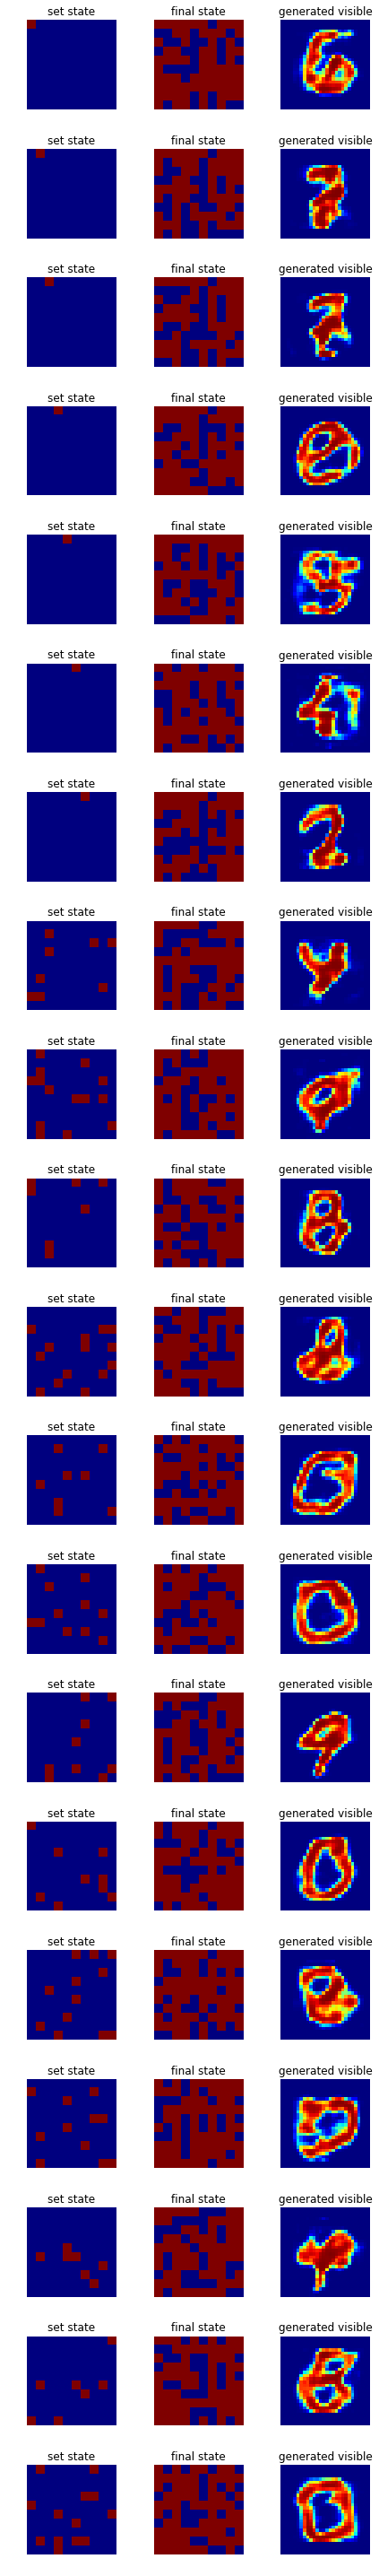

In [44]:
# Generiranje uzoraka iz slučajnih vektora
r_input = np.random.rand(100, Nh2)
r_input[r_input > 0.9] = 1 # postotak aktivnih - slobodno varirajte
r_input[r_input < 1] = 0
r_input = r_input * 20 # pojačanje za slučaj ako je mali postotak aktivnih

s = 10
i = 0
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s

out_2 = sess2.run((v_out), feed_dict={h1_out: r_input})
print (out_2.shape)

# Emulacija dodatnih Gibbsovih uzorkovanja pomoću feed_dict
for i in range(1000):
    out_2_prob, out_2, hout2 = sess2.run((v_out_prob, v_out, h2down), feed_dict={X2: out_2})

draw_generated(r_input, hout2, out_2_prob, v_shape, h2_shape, 20)

In [45]:
Nh2 = 784
g2_transposed = tf.Graph()
with g2_transposed.as_default():
    
    X2 = tf.placeholder("float", [None, Nv])
    w1a = tf.Variable(w1s)
    vb1a = tf.Variable(vb1s)
    hb1a = tf.Variable(hb1s)
    w2 = tf.Variable(tf.transpose(w1s))
    hb2 = bias([Nh2])

    h1up_prob = tf.nn.sigmoid(tf.matmul(X2, w1a) + tf.transpose(hb1a))
    h1up = sample_prob(h1up_prob)
    h2up_prob = tf.nn.sigmoid(tf.matmul(h1up, w2) + tf.transpose(hb2))
    h2up = sample_prob(h2up_prob)
    h2down = h2up

    for step in range(gibbs_sampling_steps):
        h1down_prob = tf.nn.sigmoid(tf.matmul(h2down, tf.transpose(w2)) + tf.transpose(hb1a))
        h1down = sample_prob(h1down_prob)
        h2down_prob = tf.nn.sigmoid(tf.matmul(h1down, w2) + tf.transpose(hb2))
        h2down = sample_prob(h2down_prob)

    w2_positive_grad = tf.matmul(tf.transpose(h1up_prob), h2up_prob)
    w2_negative_grad = tf.matmul(tf.transpose(h1down_prob), h2down_prob)

    dw2 = (w2_positive_grad - w2_negative_grad) / tf.to_float(tf.shape(h1up)[0])

    update_w2 = tf.assign_add(w2, alpha * dw2)
    update_hb1a = tf.assign_add(hb1a, alpha * tf.reduce_mean(h1up - h1down, 0))
    update_hb2 = tf.assign_add(hb2, alpha * tf.reduce_mean(h2up - h2down, 0))

    out2 = (update_w2, update_hb1a, update_hb2)

    # rekonstrukcija ulaza na temelju krovnog skrivenog stanja h3
    # ...
    # ...
    h1_out_prob = tf.nn.sigmoid(tf.matmul(h2down, tf.transpose(w2)) + tf.transpose(hb1a))
    h1_out = sample_prob(h1_out_prob)
    v_out_prob = tf.nn.sigmoid(tf.matmul(h1_out, tf.transpose(w1a)) + tf.transpose(vb1a))
    v_out = sample_prob(v_out_prob)


    err2 = X2 - v_out_prob
    err_sum2 = tf.reduce_mean(err2 * err2)

    initialize2_t = tf.global_variables_initializer()

0 0.041418936
5500 0.025643593
11000 0.025958821
16500 0.028875116
22000 0.02938586
27500 0.026020832
33000 0.027080912
38500 0.029799497
44000 0.025837086
49500 0.029287731


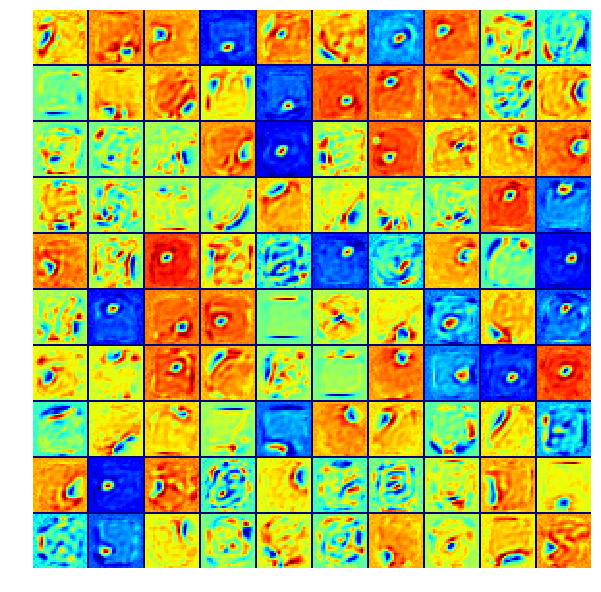

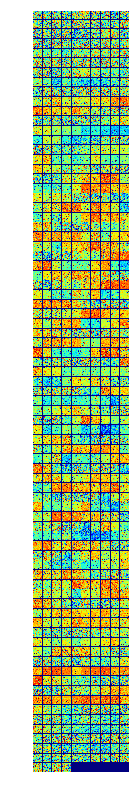

In [46]:
sess2_t = tf.Session(graph=g2_transposed)
sess2_t.run(initialize2_t)
for i in range(total_batch):
    # iteracije treniranja 
    #...
    #...
    batch, label = mnist.train.next_batch(batch_size)
    err, _ = sess2_t.run([err_sum2, out2], feed_dict={X2: batch})
    if i%(int(total_batch/10)) == 0:
        print(i, err)
    
        
w2s, hb1as, hb2s = sess2_t.run([w2, hb1a, hb2], feed_dict={X2: batch})
vr2, h2downs = sess2_t.run([v_out_prob, h2down], feed_dict={X2: teX[0:Nu,:]})

# vizualizacija težina
draw_weights(w1s, v_shape, Nh, h1_shape, interpolation="nearest")

draw_weights(w2s, h1_shape, Nh2, h2_shape, interpolation="nearest")

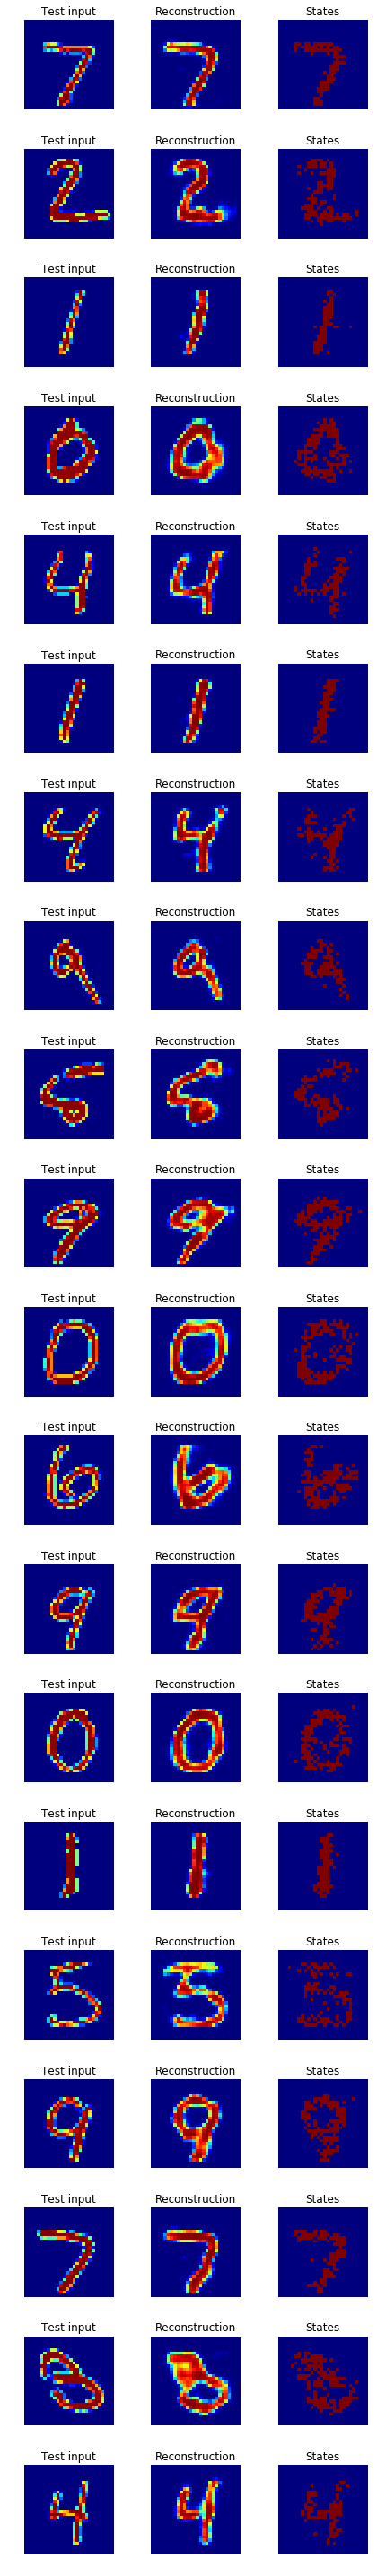

In [47]:
# vizualizacija rekonstrukcije i stanja
draw_reconstructions(teX, vr2, h2downs, v_shape, (28, 28), 20)

(100, 784)


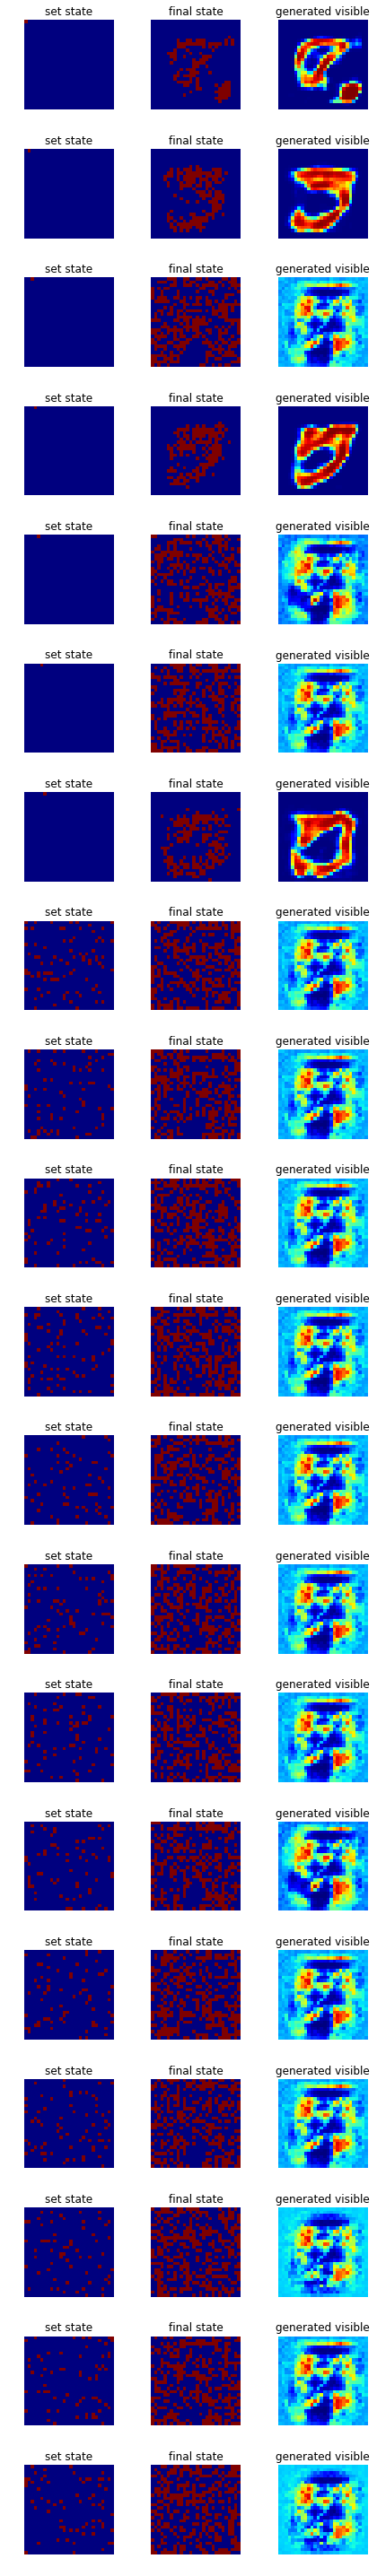

In [48]:
# Generiranje uzoraka iz slučajnih vektora
r_input = np.random.rand(100, Nh2)
r_input[r_input > 0.9] = 1 # postotak aktivnih - slobodno varirajte
r_input[r_input < 1] = 0
r_input = r_input * 20 # pojačanje za slučaj ako je mali postotak aktivnih

s = 10
i = 0
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s
i += 1
r_input[i,:] = 0
r_input[i,i]= s

out_2 = sess2_t.run((v_out), feed_dict={h2down: r_input})
print (out_2.shape)

# Emulacija dodatnih Gibbsovih uzorkovanja pomoću feed_dict
for i in range(1000):
    out_2_prob, out_2, hout2 = sess2_t.run((v_out_prob, v_out, h2down), feed_dict={X2: out_2})

draw_generated(r_input, hout2, out_2_prob, v_shape, (28, 28), 20)

<h1> TASK 3 </h1>

<h2> Config </h2>

In [49]:
beta = 0.01
batch_size = 100
epochs = 100
n_samples = mnist.train.num_examples

total_batch = int(n_samples / batch_size) * epochs

In [50]:
g3 = tf.Graph()
with g3.as_default():

    X3 = tf.placeholder("float", [None, Nv])
    r1_up = tf.Variable(w1s)
    w1_down = tf.Variable(tf.transpose(w1s))
    w2a = tf.Variable(w2s)
    hb1_up = tf.Variable(hb1s)
    hb1_down = tf.Variable(hb1as)
    vb1_down = tf.Variable(vb1s)
    hb2a = tf.Variable(hb2s)
    
    # wake pass
    h1_up_prob = tf.nn.sigmoid(tf.matmul(X3, r1_up) + tf.transpose(hb1_up))
    h1_up = sample_prob(h1_up_prob) # s^{(n)} u pripremi
    v1_up_down_prob = tf.nn.sigmoid(tf.matmul(h1_up, w1_down) + tf.transpose(vb1_down))
    v1_up_down = sample_prob(v1_up_down_prob) # s^{(n-1)\mathit{novo}} u tekstu pripreme
    
    
    # top RBM Gibs passes
    h2_up_prob = tf.nn.sigmoid(tf.matmul(h1_up, w2a) + tf.transpose(hb2a))
    h2_up = sample_prob(h2_up_prob)
    h2_down = h2_up
    for step in range(gibbs_sampling_steps):
        h1_down_prob = tf.nn.sigmoid(tf.matmul(h2_down, tf.transpose(w2a)) + tf.transpose(hb1_down))
        h1_down = sample_prob(h1_down_prob)
        h2_down_prob = tf.nn.sigmoid(tf.matmul(h1_down, w2a) + tf.transpose(hb2a))
        h2_down = sample_prob(h2_down_prob)
       
    # sleep pass
    v1_down_prob = tf.nn.sigmoid(tf.matmul(h1_down, w1_down) + tf.transpose(vb1_down))
    v1_down = sample_prob(v1_down_prob) # s^{(n-1)} u pripremi
    h1_down_up_prob = tf.nn.sigmoid(tf.matmul(v1_down, r1_up) + tf.transpose(hb1_up))
    h1_down_up = sample_prob(h1_down_up_prob) # s^{(n)\mathit{novo}} u pripremi
    
    
    # generative weights update during wake pass
    update_w1_down = tf.assign_add(w1_down, beta * tf.matmul(tf.transpose(h1_up), X3 - v1_up_down_prob) / tf.to_float(tf.shape(X3)[0]))
    update_vb1_down = tf.assign_add(vb1_down, beta * tf.reduce_mean(X3 - v1_up_down_prob, 0))
    
    
    # top RBM update
    w2_positive_grad = tf.matmul(tf.transpose(h1_up_prob), h2_up_prob)
    w2_negative_grad = tf.matmul(tf.transpose(h1_down_prob), h2_down_prob)
    dw3 = (w2_positive_grad - w2_negative_grad) / tf.to_float(tf.shape(h1_up)[0])
    update_w2 = tf.assign_add(w2a, beta * dw3)
    update_hb1_down = tf.assign_add(hb1_down, beta * tf.reduce_mean(h1_up - h1_down, 0))
    update_hb2 = tf.assign_add(hb2a, beta * tf.reduce_mean(h2_up - h2_down, 0))
    
    # recognition weights update during sleep pass
    update_r1_up = tf.assign_add(r1_up, beta * tf.matmul(tf.transpose(v1_down_prob), h1_down - h1_down_up) / tf.to_float(tf.shape(X3)[0]))
    update_hb1_up = tf.assign_add(hb1_up, beta * tf.reduce_mean(h1_down - h1_down_up, 0))
    
    out3 = (update_w1_down, update_vb1_down, update_w2, update_hb1_down, update_hb2, update_r1_up, update_hb1_up)
    
    err3 = X3 - v1_down_prob
    err_sum3 = tf.reduce_mean(err3 * err3)
    
    initialize3 = tf.global_variables_initializer()


In [51]:
sess3 = tf.Session(graph=g3)
sess3.run(initialize3)
for i in range(total_batch):
    #...
    batch, label = mnist.train.next_batch(batch_size)
    err, _ = sess3.run([err_sum3, out3], feed_dict={X3: batch})
        
    if i%(int(total_batch/10)) == 0:
        print(i, err)
    
w2ss, r1_ups, w1_downs, hb2ss, hb1_ups, hb1_downs, vb1_downs = sess3.run(
    [w2a, r1_up, w1_down, hb2a, hb1_up, hb1_down, vb1_down], feed_dict={X3: batch})
vr3, h2_downs, h2_down_probs = sess3.run([v1_down_prob, h2_down, h2_down_prob], feed_dict={X3: teX[0:Nu,:]})



0 0.021742733
5500 0.021704126
11000 0.020896982
16500 0.020435547
22000 0.02175566
27500 0.020732185
33000 0.01889517
38500 0.020762969
44000 0.020177918
49500 0.019041635


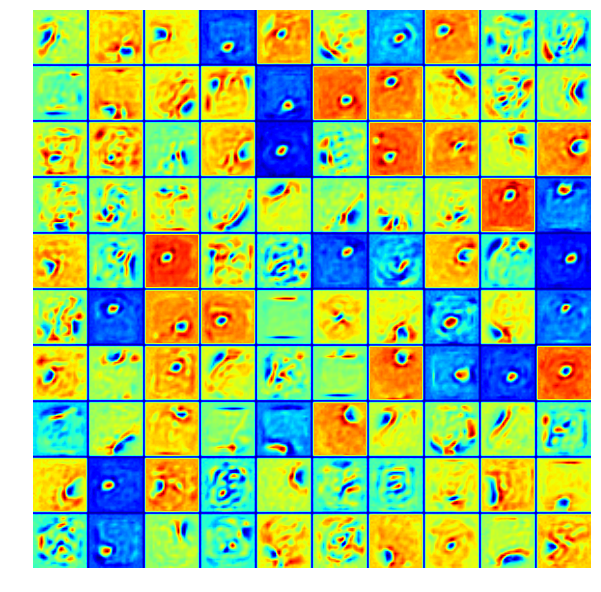

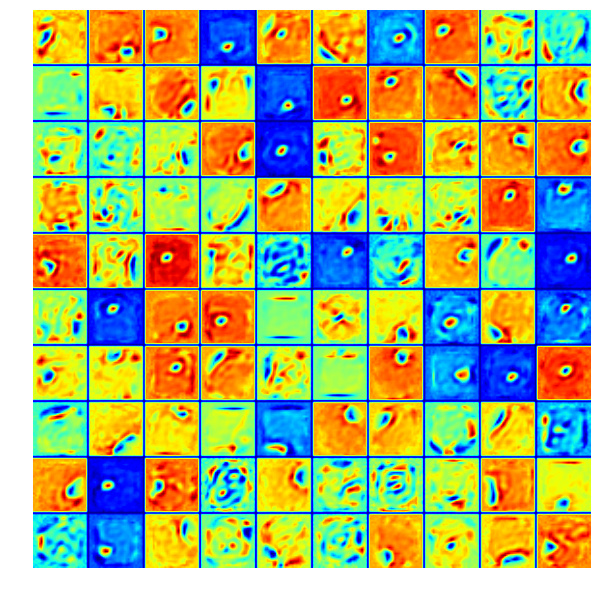

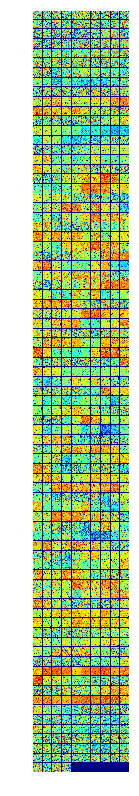

In [52]:
# vizualizacija težina
draw_weights(r1_ups, v_shape, Nh, h1_shape)
draw_weights(w1_downs.T, v_shape, Nh, h1_shape)
draw_weights(w2ss, h1_shape, Nh2, h2_shape, interpolation="nearest")

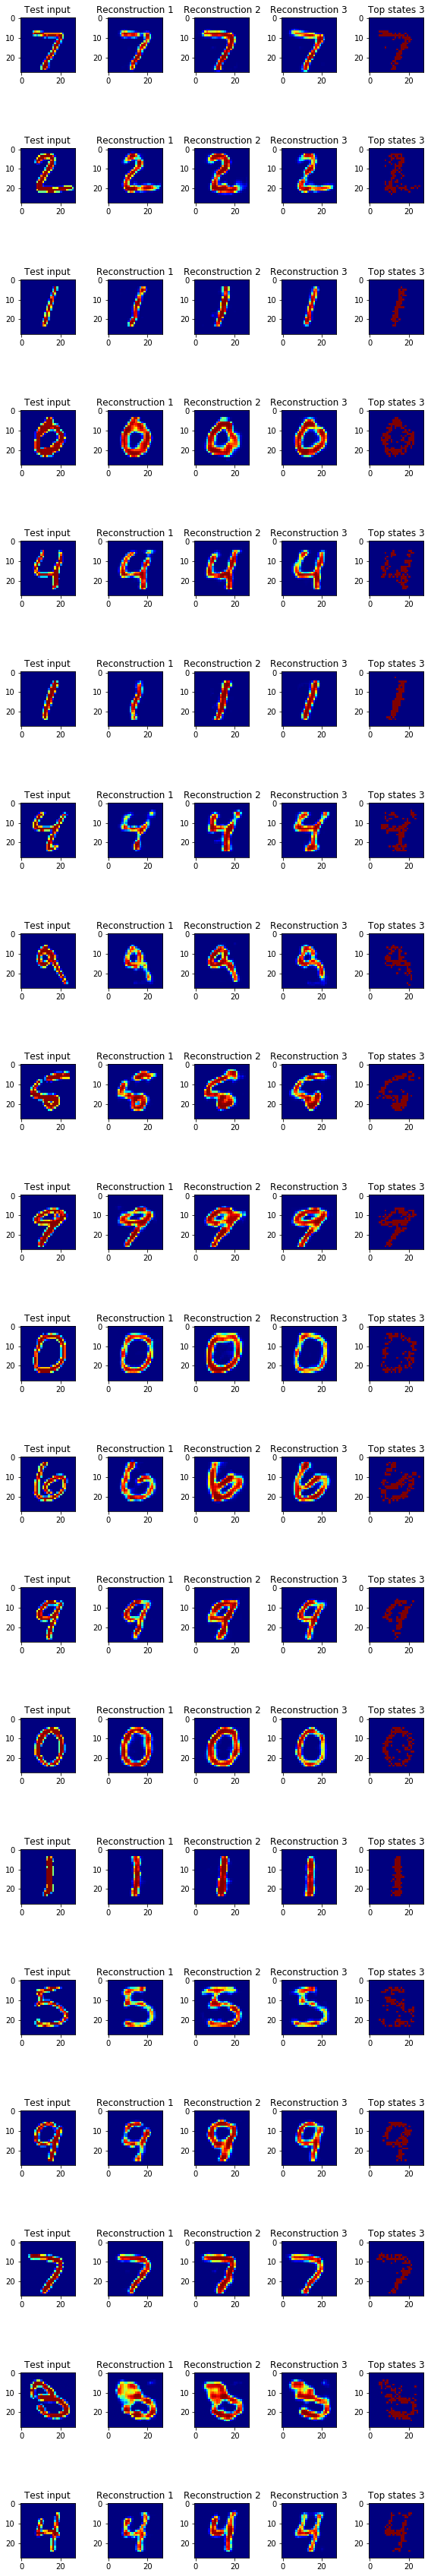

In [53]:
# vizualizacija rekonstrukcije i stanja
Npics = 5
plt.figure(figsize=(8, 12*4))
for i in range(20):

    plt.subplot(20, Npics, Npics*i + 1)
    plt.imshow(teX[i].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Test input")
    plt.subplot(20, Npics, Npics*i + 2)
    plt.imshow(vr[i][0:784].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Reconstruction 1")
    plt.subplot(20, Npics, Npics*i + 3)
    plt.imshow(vr2[i][0:784].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Reconstruction 2")
    plt.subplot(20, Npics, Npics*i + 4)
    plt.imshow(vr3[i][0:784].reshape(v_shape), vmin=0, vmax=1)
    plt.title("Reconstruction 3")
    plt.subplot(20, Npics, Npics*i + 5)
    plt.imshow(h2_downs[i][0:Nh2].reshape((28, 28)), vmin=0, vmax=1, interpolation="nearest")
    plt.title("Top states 3")
plt.tight_layout()

# Generiranje uzoraka iz slučajnih vektora krovnog skrivenog sloja
#...
#...
# Emulacija dodatnih Gibbsovih uzorkovanja pomoću feed_dict
#...
#...

<h1> TASK 4 </h1>

In [54]:
learning_rate = 0.001
batch_size = 100

n_hidden_recog_1=200 # 1 sloj enkodera
n_hidden_recog_2=200 # 2 sloj enkodera
n_hidden_gener_1=200 # 1 sloj dekodera
n_hidden_gener_2=200 # 2 sloj dekodera
n_z=20 # broj skrivenih varijabli
n_input=784 # MNIST data input (img shape: 28*28)
in_shape = (28,28)
mnist = input_data.read_data_sets('../MNIST_data/', one_hot=True)
n_samples = mnist.train.num_examples

Extracting ../MNIST_data/train-images-idx3-ubyte.gz
Extracting ../MNIST_data/train-labels-idx1-ubyte.gz
Extracting ../MNIST_data/t10k-images-idx3-ubyte.gz
Extracting ../MNIST_data/t10k-labels-idx1-ubyte.gz


In [55]:
def get_canvas(Z, ind, nx, ny, in_shape, batch_size, sess):
    """Crtanje rekonstrukcija na odgovarajućim pozicijama u 2D prostoru skrivenih varijabli
    Z -- skriveni vektori raspoređeni u gridu oko ishodišta
    ind -- indeksi za rezanje Z-a na batch_size blokove za slanje u graf -zbog problema sa random generatorom
    nx -- raspon grida po x osi - skrivena varijabla z0
    ny -- raspon grida po y osi - skrivena varijabla z1
    in_shape -- dimenzije jedne rekonstrukcije i.e. ulazne sličice
    batch_size -- veličina minibatcha na koji je graf naviknut
    sess -- session grafa mreže
    """
    # get reconstructions for visualiations
    X = np.empty((0,in_shape[0]*in_shape[1])) # empty array for concatenation 
    # split hidden vectors into minibatches of batch_size due to TF random generator limitation
    for batch in np.array_split(Z,ind):
        # fill up last batch to full batch_size if neccessary
        # this addition will not be visualized, but is here to avoid TF error
        if batch.shape[0] < batch_size:
            batch = np.concatenate((batch, np.zeros((batch_size-batch.shape[0], batch.shape[1]))), 0)
        # get batch_size reconstructions and add them to array of previous reconstructions
        X = np.vstack((X, sess.run(x_reconstr_mean_out, feed_dict={z: batch})))
    # make canvas with reconstruction tiles arranged by the hidden state coordinates of each reconstruction
    # this is achieved for all reconstructions by clever use of reshape, swapaxes and axis inversion
    return (X[0:nx*ny,:].reshape((nx*ny,in_shape[0],in_shape[1])).swapaxes(0,1)
            .reshape((in_shape[0],ny,nx*in_shape[1])).swapaxes(0,1)[::-1,:,:]
            .reshape((ny*in_shape[0],nx*in_shape[1])))

def draw_reconstructions(ins, outs, states, shape_in, shape_state):
    """Vizualizacija ulaza i pripadajućih rekonstrkcija i stanja skrivenog sloja
    ins -- ualzni vektori
    outs -- rekonstruirani vektori
    states -- vektori stanja skrivenog sloja
    shape_in -- dimezije ulaznih slika npr. (28,28)
    shape_state -- dimezije za 2D prikaz stanja (npr. za 100 stanja (10,10)
    """
    print(ins.shape) # 100x784
    print(outs.shape) # 100x784
    print(states.shape) # 100x2
    print(shape_in) # 28x28
    print(shape_state)
    plt.figure(figsize=(8, 12*4))
    for i in range(20):

        plt.subplot(20, 4, 4*i + 1)
        plt.imshow(ins[i].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Test input")
        plt.subplot(20, 4, 4*i + 2)
        plt.imshow(outs[i][0:784].reshape(shape_in), vmin=0, vmax=1, interpolation="nearest")
        plt.title("Reconstruction")
        plt.subplot(20, 4, 4*i + 3)
        plt.imshow(states[i][0:(shape_state[0] * shape_state[1])].reshape(shape_state),
                   vmin=-4, vmax=4, interpolation="nearest")
        plt.colorbar()
        plt.title("States")
    plt.tight_layout()
    
def plot_latent(inmat, labels):
    """Crtanje pozicija uzoraka u 2D latentnom prostoru
    inmat -- matrica latentnih stanja
    labels -- labela klas
    """
    plt.figure(figsize=(8, 6)) 
    plt.axis([-4, 4, -4, 4])
    plt.gca().set_autoscale_on(False)

    plt.scatter(inmat[:, 0], inmat[:, 1], c=np.argmax(labels, 1))
    plt.colorbar()
    plt.xlabel('z0')
    plt.ylabel('z1')

def save_latent_plot(name):
    """Spremanje trenutnog figure-a
    name -- ime datoteke
    """
    plt.savefig(name)
    
def weight_variable(shape, name):
    """Kreiranje težina"""
    # http://andyljones.tumblr.com/post/110998971763/an-explanation-of-xavier-initialization
    return tf.get_variable(name, shape=shape,
            initializer=tf.contrib.layers.xavier_initializer())

def bias_variable(shape):
    """Kreiranje pomaka"""
    initial = tf.zeros(shape, dtype=tf.float32)
    return tf.Variable(initial)

def variable_summaries(var, name):
    """Prikupljanje podataka za Tensorboard"""
    with tf.name_scope(name):
        mean = tf.reduce_mean(var)
        tf.summary.scalar('mean', mean)
        stddev = tf.sqrt(tf.reduce_mean(tf.square(var - mean)))
        tf.summary.scalar('stddev', stddev)
        tf.summary.scalar('max', tf.reduce_max(var))
        tf.summary.scalar('min', tf.reduce_min(var))
        tf.summary.histogram(name, var)

def vae_layer(input_tensor, input_dim, output_dim, layer_name, act=tf.nn.softplus):
    """Kreiranje jednog skrivenog sloja"""
    # Adding a name scope ensures logical grouping of the layers in the graph.
    with tf.name_scope(layer_name):
        # This Variable will hold the state of the weights for the layer
        weights = weight_variable([input_dim, output_dim], layer_name + '/weights')
        variable_summaries(weights,'weights')
        tf.summary.tensor_summary('weightsT', weights)
        biases = bias_variable([output_dim])
        variable_summaries(biases, 'biases')
        preactivate = tf.matmul(input_tensor, weights) + biases
        tf.summary.histogram('pre_activations', preactivate)
        activations = act(preactivate, name='activation')
        tf.summary.histogram('activations', activations)
    return activations


In [56]:
tf.reset_default_graph() 
    
sess = tf.InteractiveSession()
        
# definicije ulaznog tenzora
x = tf.placeholder("float", [None, n_input])

# definirajte enkoiderski dio
layer_e1 = vae_layer(x, n_input, n_hidden_recog_1, 'layer_e1') 
layer_e2 = vae_layer(layer_e1, n_hidden_recog_1, n_hidden_recog_2, 'layer_e2')

with tf.name_scope('z'):
# definirajte skrivene varijable i pripadajući generator šuma
    z_mean = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_mean', act=tf.identity)
    z_log_sigma_sq = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_log_sigma_sq', act=tf.identity)
    eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32)
                         
    z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
    tf.summary.histogram('activations', z)

# definirajte dekoderski dio
layer_d1 = vae_layer(z, n_z, n_hidden_gener_1, 'layer_d1') 
layer_d2 = vae_layer(layer_d1, n_hidden_gener_1, n_hidden_gener_2, 'layer_d2')
            
# definirajte srednju vrijednost rekonstrukcije
x_reconstr_mean = vae_layer(layer_d2, n_hidden_gener_2, n_input, 'x_reconstr_mean', act=tf.identity)

x_reconstr_mean_out = tf.nn.sigmoid(x_reconstr_mean)

# definirajte dvije komponente funkcije cijene
with tf.name_scope('cost'):
    cost1 = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels = x, logits = x_reconstr_mean), 1)
    tf.summary.histogram('cross_entropy', cost1)
    cost2 = -1/2 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1)
    tf.summary.histogram('D_KL', cost2)
    cost = tf.reduce_mean(cost1 + cost2)   # average over batch
    tf.summary.histogram('cost', cost)
    

                         
# ADAM optimizer
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Prikupljanje podataka za Tensorboard
merged = tf.summary.merge_all()

init = tf.global_variables_initializer()

saver = tf.train.Saver()

n_epochs = 100
train_writer = tf.summary.FileWriter('train', sess.graph)

sess.run(init)


In [57]:
import os 

total_batch = int(n_samples / batch_size)
step = 0
for epoch in range(n_epochs):
    avg_cost = 0.
        
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        opt, cos = sess.run((optimizer, cost), feed_dict={x: batch_xs})
        # Compute average loss
        avg_cost += cos / n_samples * batch_size
        
    # Display logs per epoch step
    if epoch%(int(n_epochs/10)) == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(avg_cost)) 
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        summary, _ = sess.run([merged, optimizer], feed_dict={x: batch_xs}, 
                              options=run_options, run_metadata=run_metadata)
        train_writer.add_run_metadata(run_metadata, 'epoch%03d' % epoch)
        train_writer.add_summary(summary, i)
        
        saver.save(sess, os.path.join('train', "model_20.ckpt"), epoch)

train_writer.close()

Epoch: 0001 cost= 178.862833141
Epoch: 0011 cost= 106.229847787
Epoch: 0021 cost= 102.314227850
Epoch: 0031 cost= 100.652719657
Epoch: 0041 cost= 99.608186729
Epoch: 0051 cost= 98.905578932
Epoch: 0061 cost= 98.339222898
Epoch: 0071 cost= 97.880099210
Epoch: 0081 cost= 97.540905900
Epoch: 0091 cost= 97.257782634


In [58]:
n_z = 2 

In [59]:
tf.reset_default_graph() 
    
sess = tf.InteractiveSession()
        
# definicije ulaznog tenzora
x = tf.placeholder("float", [None, n_input])

# definirajte enkoiderski dio
layer_e1 = vae_layer(x, n_input, n_hidden_recog_1, 'layer_e1') 
layer_e2 = vae_layer(layer_e1, n_hidden_recog_1, n_hidden_recog_2, 'layer_e2')

with tf.name_scope('z'):
# definirajte skrivene varijable i pripadajući generator šuma
    z_mean = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_mean', act=tf.identity)
    z_log_sigma_sq = vae_layer(layer_e2, n_hidden_recog_2, n_z, 'z_log_sigma_sq', act=tf.identity)
    eps = tf.random_normal((batch_size, n_z), 0, 1, dtype=tf.float32)
                         
    z = tf.add(z_mean, tf.multiply(tf.sqrt(tf.exp(z_log_sigma_sq)), eps))
    tf.summary.histogram('activations', z)

# definirajte dekoderski dio
layer_d1 = vae_layer(z, n_z, n_hidden_gener_1, 'layer_d1') 
layer_d2 = vae_layer(layer_d1, n_hidden_gener_1, n_hidden_gener_2, 'layer_d2')
            
# definirajte srednju vrijednost rekonstrukcije
x_reconstr_mean = vae_layer(layer_d2, n_hidden_gener_2, n_input, 'x_reconstr_mean', act=tf.identity)

x_reconstr_mean_out = tf.nn.sigmoid(x_reconstr_mean)

# definirajte dvije komponente funkcije cijene
with tf.name_scope('cost'):
    cost1 = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(labels = x, logits = x_reconstr_mean), 1)
    tf.summary.histogram('cross_entropy', cost1)
    cost2 = -1/2 * tf.reduce_sum(1 + z_log_sigma_sq - tf.square(z_mean) - tf.exp(z_log_sigma_sq), 1)
    tf.summary.histogram('D_KL', cost2)
    cost = tf.reduce_mean(cost1 + cost2)   # average over batch
    tf.summary.histogram('cost', cost)
    

                         
# ADAM optimizer
with tf.name_scope('train'):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)

# Prikupljanje podataka za Tensorboard
merged = tf.summary.merge_all()

init = tf.global_variables_initializer()

saver = tf.train.Saver()

n_epochs = 100
train_writer = tf.summary.FileWriter('train', sess.graph)

sess.run(init)


In [60]:
total_batch = int(n_samples / batch_size)
step = 0
for epoch in range(n_epochs):
    avg_cost = 0.
        
    for i in range(total_batch):
        batch_xs, _ = mnist.train.next_batch(batch_size)
        # Fit training using batch data
        opt, cos = sess.run((optimizer, cost), feed_dict={x: batch_xs})
        # Compute average loss
        avg_cost += cos / n_samples * batch_size
        
    # Display logs per epoch step
    if epoch%(int(n_epochs/10)) == 0:
        print("Epoch:", '%04d' % (epoch+1),
              "cost=", "{:.9f}".format(avg_cost)) 
        run_options = tf.RunOptions(trace_level=tf.RunOptions.FULL_TRACE)
        run_metadata = tf.RunMetadata()
        summary, _ = sess.run([merged, optimizer], feed_dict={x: batch_xs}, 
                              options=run_options, run_metadata=run_metadata)
        train_writer.add_run_metadata(run_metadata, 'epoch%03d' % epoch)
        train_writer.add_summary(summary, i)
        
        saver.save(sess, os.path.join('train', "model_2.ckpt"), epoch)

train_writer.close()

Epoch: 0001 cost= 194.910166210
Epoch: 0011 cost= 150.169823581
Epoch: 0021 cost= 145.577563865
Epoch: 0031 cost= 143.650968489
Epoch: 0041 cost= 142.448423906
Epoch: 0051 cost= 141.459674683
Epoch: 0061 cost= 140.568953469
Epoch: 0071 cost= 139.987587377
Epoch: 0081 cost= 139.458782973
Epoch: 0091 cost= 139.002200720


(100, 784)
(100, 784)
(100, 2)
(28, 28)
(2, 1)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

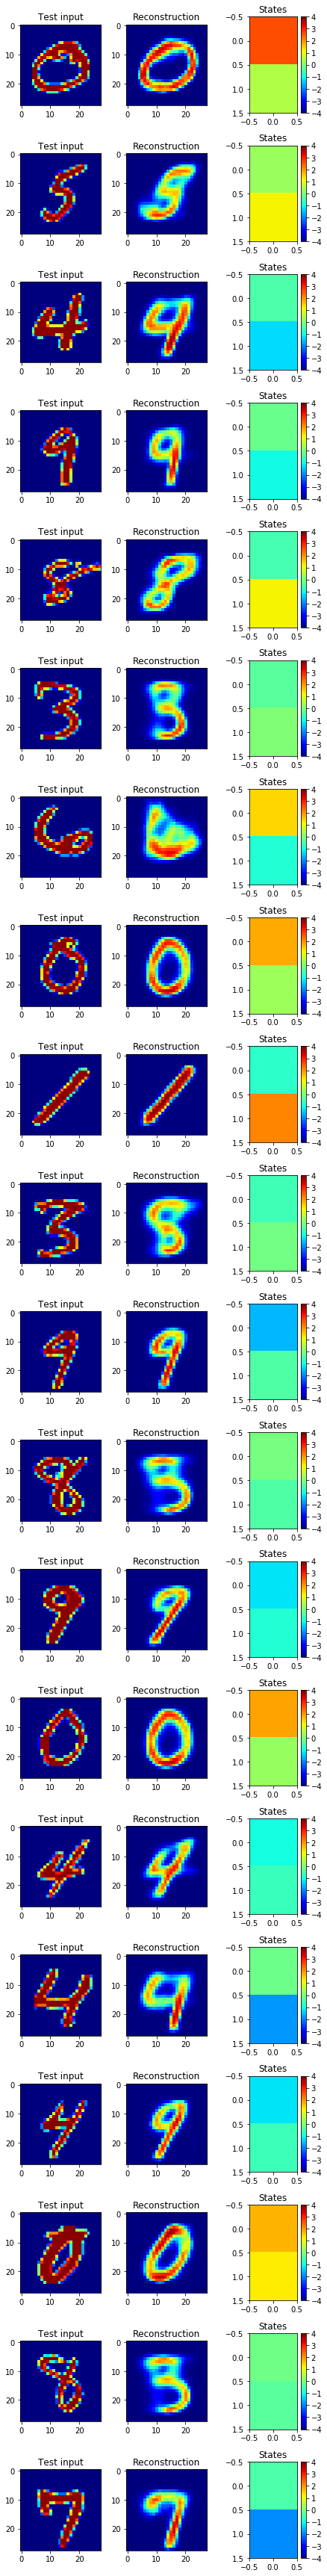

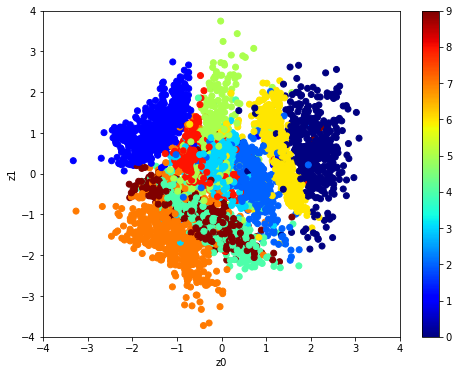

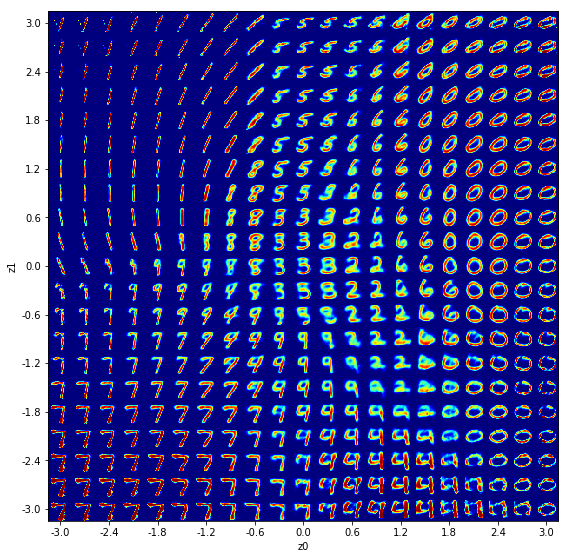

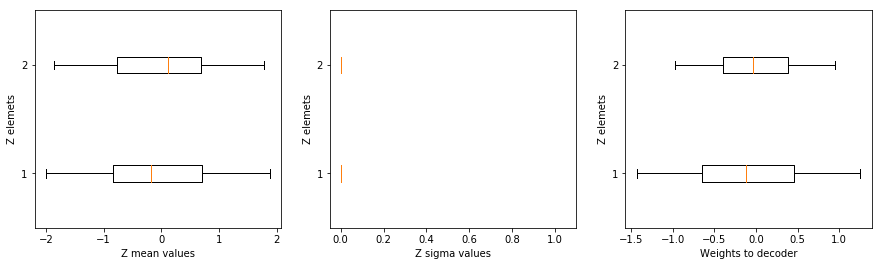

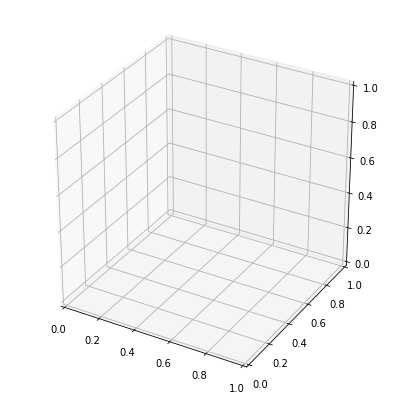

In [61]:
# vizualizacija rekonstrukcije i stanja
x_sample = mnist.test.next_batch(100)[0]
x_reconstruct, z_out = sess.run([x_reconstr_mean_out, z], feed_dict={x: x_sample})

draw_reconstructions(x_sample, x_reconstruct, z_out, (28, 28), (2, 1)) # prilagodite dimenzije prema potrebi

# Vizualizacija raspored testnih uzoraka u 2D prostoru skrivenih varijabli - 1. način
x_sample, y_sample = mnist.test.next_batch(5000)
z_mu, z_sigma = sess.run((z_mean, z_log_sigma_sq), feed_dict={x: x_sample})
    
plot_latent(z_mu, y_sample)
#save_latent_plot('trt.png')

# Vizualizacija raspored testnih uzoraka u 2D prostoru skrivenih varijabli - 2. način

nx = ny = 21
x_values = np.linspace(-3, 3, nx)
y_values = np.linspace(-3, 3, ny)

canvas = np.empty((28*ny, 28*nx))

# Trikovito popunjavanje rezultata za grid zbog fiksirane veličine z batcha u grafu
# Valjda će se to riješiti u nekoj budućoj verziji TF
Xi, Yi = np.meshgrid(x_values, y_values)
Z = np.column_stack((Xi.flatten(), Yi.flatten()))
X = np.empty((0,28*28))
ind = list(range(batch_size, nx*ny, batch_size))
for i in np.array_split(Z,ind):
    if i.shape[0] < batch_size:
        i = np.concatenate((i, np.zeros((batch_size-i.shape[0], i.shape[1]))), 0)
    if i.shape[1] != n_z:
        # i = np.concatenate((i, np.zeros((i.shape[0], n_z - i.shape[1]))), 1)
        print('This is where it breaks')
    X = np.vstack((X, sess.run(x_reconstr_mean_out, feed_dict={z: i})))
    
for i, yi in enumerate(y_values):
    for j, xi in enumerate(x_values):
        canvas[(nx-i-1)*28:(nx-i)*28, j*28:(j+1)*28] = X[i*nx+j].reshape(28, 28)

plt.figure(figsize=(8, 10))
plt.imshow(canvas, origin="upper")
plt.xticks( np.linspace(14,588-14,11), np.round(np.linspace(-3,3,11), 2) )
plt.yticks( np.linspace(14,588-14,11), np.round(np.linspace(3,-3,11), 2) )
plt.xlabel('z0')
plt.ylabel('z1')
plt.tight_layout()

# Vizualizacija ugašenih elemenata skrivenog sloja - 1. način

# Pomoćna funkcija za crtanje boxplot grafova
def boxplot_vis(pos, input_data, label_x, label_y):
    ax = fig.add_subplot(130+pos)
    plt.boxplot(input_data, 0, '', 0, 0.75)
    ax.set_xlabel(label_x)
    ax.set_ylabel(label_y)
    return ax
   
fig = plt.figure(figsize=(15,4))

# Vizualizacija statistike za z_mean
boxplot_vis(1,z_mu, 'Z mean values', 'Z elemets')

# Vizualizacija statistike za z_sigma
ax = boxplot_vis(2, np.square(np.exp(z_sigma)), 'Z sigma values', 'Z elemets')
ax.set_xlim([-0.05,1.1])

# Vizualizacija statistike za težine ulaza u dekoder
test = tf.get_default_graph().get_tensor_by_name("layer_d1/weights:0")
weights_d1 = test.eval(session=sess)
boxplot_vis(3, weights_d1.T, 'Weights to decoder', 'Z elemets')


# Vizualizacija ugašenih elemenata skrivenog sloja - 2. način

from mpl_toolkits.mplot3d import Axes3D

# Funkcija za crtanje 3D bar grafa
def bargraph_vis(pos, input_data, dims, color, labels):
    ax = fig.add_subplot(120+pos, projection='3d')
    xpos, ypos = np.meshgrid(range(dims[0]), range(dims[1]))
    xpos = xpos.flatten('F')
    ypos = ypos.flatten('F')
    zpos = np.zeros_like(xpos)
    
    dx = np.ones_like(zpos) 
    dy = np.ones_like(zpos) * 0.5
    dz = input_data.flatten()
    
    ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=color)
    ax.view_init(elev=30., azim=5)
    ax.set_xlabel(labels[0])
    ax.set_ylabel(labels[1])
    ax.set_zlabel(labels[2])
                             
fig = plt.figure(figsize=(15,7))

# 3D bar graf za z_mean
labels = ('Samples', 'Hidden elements', 'Z mean')
bargraph_vis(1, z_mu, [200, z_mu.shape[1]], 'g', labels)

# 3D bar graf za težine iz z_mena u dekoder
labels = ('Decoder elements', 'Hidden elements Z', 'Weights')
bargraph_vis(2, weights_d1.T, weights_d1.T.shape, 'y', labels)

